# Road Extraction

## Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import torch
import random
import cv2
import tqdm
from matplotlib import pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as album
from PIL import Image

%matplotlib inline

/home/ah2719/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Global Variables

In [2]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASS_NAMES = ['road', 'background']
CLASS_RGB_VALUES = [[255,255,255], [0,0,0]]
IMG_SIZE = 1024
IMG_PATH = '/home/ah2719/FYP/Spatial_Finance_Transport/data/xView_example_image.PNG'
PRED_MASK_IMG_PATH = '/home/ah2719/FYP/Spatial_Finance_Transport/data/pred_mask.jpeg'

MODEL_PATH = '/home/ah2719/FYP/Spatial_Finance_Transport/models/road_extraction_model.pth'
MODEL_STATE_DICT_PATH = '/home/ah2719/FYP/Spatial_Finance_Transport/models/road_extraction_state_dict.pth'

# Get RGB values of required classes
SELECT_CLASS_INDICES = [CLASS_NAMES.index(cls.lower()) for cls in CLASS_NAMES]
SELECT_CLASS_RGB_VALUES =  np.array(CLASS_RGB_VALUES)[SELECT_CLASS_INDICES]

## Helper Functions

In [3]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [4]:
# Perform one hot encoding on label (TRAINING ONLY)
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [5]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

In [6]:
# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(pred_mask, img):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """


    result_img = np.empty(img.shape)

    print("pred_mask shape: {}".format(pred_mask.shape))
    
    for i in range(IMG_SIZE):
        for j in range(IMG_SIZE):
            if np.any(pred_mask[i][j]):
                result_img[i][j] = img[i][j]
            else:
                result_img[i][j] = np.array([0,0,0])
    

    where = np.where(pred_mask == 1)

    print("final result_img shape: {}".format(result_img.shape))
    return result_img

In [7]:
def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

In [8]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## Road Extraction Model
https://ieeexplore.ieee.org/document/8127098

https://www.kaggle.com/code/balraj98/road-extraction-from-satellite-images-deeplabv3/notebook

In [9]:
# May need to refer to https://www.kaggle.com/code/balraj98/road-extraction-from-satellite-images-deeplabv3/comments if errors
#model = torch.load(MODEL_PATH)

In [10]:
chkpt = torch.load(MODEL_STATE_DICT_PATH)
model = smp.DeepLabV3Plus(
    encoder_name='resnet50', 
    encoder_weights='imagenet', 
    classes=2, 
    activation='sigmoid',
)
model.load_state_dict(chkpt)
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

## Test Data Predictions

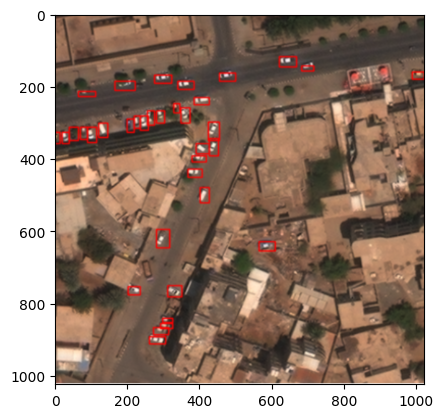

In [11]:
# Random inference on a dataset not used for training process
random_idx = random.randint(1,10)
img = cv2.imread(IMG_PATH)
img= cv2.resize(img,(IMG_SIZE,IMG_SIZE))
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#show image
plt.imshow(img)

In [12]:
# preprocessing
img_preprocessed= preprocessing_fn(img)
x_tensor  = to_tensor(img_preprocessed)
x_tensor = torch.from_numpy(x_tensor).unsqueeze(0)
print(x_tensor.shape)

torch.Size([1, 3, 1024, 1024])


In [13]:
pred_mask = model(x_tensor)
pred_mask = pred_mask.squeeze().detach().numpy()
pred_mask = np.transpose(pred_mask,(1,2,0))

pred_mask_reversed = reverse_one_hot(pred_mask)
pred_mask_processed = colour_code_segmentation(pred_mask_reversed, img)

pred_mask_processed = (pred_mask_processed * 255).astype(np.uint8)

# show prediction
plt.imshow(pred_mask_processed)

: 

: 

## Save Masked Image

In [ ]:
pred_mask_im = Image.fromarray(pred_mask_processed)
pred_mask_im.save(PRED_MASK_IMG_PATH)

## Save Model State

In [ ]:
# To save model state dict
#torch.save(model.state_dict(), "/home/ah2719/FYP/Spatial_Finance_Transport/models/state_dict.pth")